In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize,fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('spx_quotedata20220308_all.xlsx')
pd.set_option('display.max_columns', 25)
df["Expiration Date"] = pd.to_datetime(df["Expiration Date"])
print(df.head())


  Expiration Date                Calls  Last Sale  Net     Bid     Ask  \
0      2022-03-09  SPXW220309C03000000       0.00  0.0  1151.7  1168.9   
1      2022-03-09  SPXW220309C03200000       0.00  0.0   951.7   969.1   
2      2022-03-09  SPXW220309C03300000       0.00  0.0   851.2   869.3   
3      2022-03-09  SPXW220309C03400000       0.00  0.0   751.7   769.1   
4      2022-03-09  SPXW220309C03500000     735.06  0.0   651.2   669.4   

   Volume      IV   Delta  Gamma  Open Interest  Strike                 Puts  \
0       0  4.3394  1.0000    0.0              0    3000  SPXW220309P03000000   
1       0  3.6439  0.9999    0.0              0    3200  SPXW220309P03200000   
2       0  3.3092  0.9999    0.0              0    3300  SPXW220309P03300000   
3       0  2.9763  0.9998    0.0              0    3400  SPXW220309P03400000   
4       0  2.6471  0.9998    0.0             10    3500  SPXW220309P03500000   

   Last Sale.1  Net.1  Bid.1  Ask.1  Volume.1    IV.1  Delta.1  Gamma.1  \

In [3]:
# Call price as middle of bid and ask
df["Mid"] = (df["Bid"] + df["Ask"]) / 2

# Put price
df["Mid.1"] = (df["Ask.1"] + df["Bid.1"])/2

S0 = 4170.7002

# List of unique maturities
maturities = df["Expiration Date"].unique()

# Define model function as call put indentity
def model(x,*args):
    S0,df_mat = args
    call_put_identity = df_mat["Mid"] - df_mat["Mid.1"] - x[0] * S0 + x[1] * df_mat["Strike"]
    return call_put_identity.values

# Define squared deviation function
def squared_deviation(x,*args):
    call_put_indentities = model(x,*args)
    return np.sum((call_put_indentities- np.mean(call_put_indentities))**2)

B0 = [0]
D0 = [0]
for maturity in maturities:
    #Ensure that we have positive zero coupon bond prices and dividend discount factors
    df_mat = df[df["Expiration Date"] == maturity]
    cons = [
        # Ensure that we have positive zero coupon bond prices and dividend discount factors
        {'type': 'ineq', 'fun': lambda x:  x[0] },
        {'type': 'ineq', 'fun': lambda x:  x[1] },

        # Add constraint to ensure that the sum of the call put identities is close to 0, necessary for the optimization to converge
        {'type': 'eq', 'fun': lambda x:  np.sum(model(x,S0,df_mat)) }
    ]   

    
    # Minimize squared deviation
    m = minimize(squared_deviation,[D0[-1],B0[-1]],args=(S0,df_mat),constraints=cons,method='SLSQP')

    D0.append(m.x[0])
    B0.append(m.x[1])

term_structure = pd.DataFrame({"Maturity":maturities,"D0":D0[1:],"B0":B0[1:]})



In [4]:
term_structure["Forward Prices"] = S0 * term_structure["D0"] / term_structure["B0"]

$$
S(T) = S_0 \exp\left( \int_0^T \left( r(t) - q(t) - \frac{1}{2} \sigma(t)^2 \right) dt + \int_0^T \sigma(t) dW(t) \right)
$$

However, since \( \sigma(t) \) is a piecewise function, we can express it as:

$$
\int_0^T \sigma(t) dt = \sum_{i=1}^{n} \int_{T_{i-1}}^{T_i} \sigma_i(t) dt
$$

Moreover, \( \sigma_i(t) \) is constant on the intervals \([T_{i-1}, T_{i}]\), so we have:

$$
\sum_{i=1}^{n} \int_{T_{i-1}}^{T_i} \sigma_i(t) dt = \sum_{i=1}^{n} \sigma_i (T_{i}-T_{i-1})
$$

And we can express the discount factor as:

$$
\exp\left(-\int_0^T r(t) dt\right) = B(0,T)
$$

This leads us to:

$$
S(T) = S(0) \frac{D(0,T)}{B(0,T)} \exp\left(-\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i \int_{T_{i-1}}^{T_i} dW(t)\right)
$$

Now, the payoff for a European call option is given by:

$$
C = \mathbb{E}_{\beta} \left[\max(S(T) - K, 0) \exp\left(-\int_0^T r(t) dt \right)\right]
$$

This can be rewritten as:

$$
C = \exp\left(-\int_0^T r(t) dt\right) \mathbb{E}_{\beta} \left[S(T) \mathbb{I}(S(T) > K)\right] - \exp\left(-\int_0^T r(t) dt\right) K \mathbb{E}_{\beta} \left[\mathbb{I}(S(T) > K)\right]
$$

Which simplifies to:

$$
C = \exp\left(-\int_0^T r(t) dt\right) \mathbb{E}_{\beta}\left[S(T) \mathbb{I}(S(T) > K)\right] - \exp\left(-\int_0^T r(t) dt\right) K \mathbb{P}_{\beta}(S(T) > K)
$$

Now, using the properties of the normal distribution, we have:

$$
\mathbb{P}_{\beta}(S(T) > K) = \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) - \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$

Next, we observe that:

$$
\frac{S(T)}{S(0)} \cdot \frac{D(0,T)}{B(0,T)} = \exp\left(-\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i \int_{T_{i-1}}^{T_i} dW(t)\right)
$$

This represents an exponential martingale. By applying Girsanov's theorem, we can change the measure from:

$$
\mathbb{P} \quad \text{to} \quad \mathbb{Q}
$$

We then have:

$$
W_Q(T_{i}) - W_Q(T_{i-1}) = W(T_{i}) - W(T_{i-1}) - \sigma_i (T_{i}-T_{i-1})
$$

Consequently, \( S(T) \) becomes:

$$
S(T) = S(0) \frac{D(0,T)}{B(0,T)} \exp\left(+\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i (W_Q(T_{i}) - W_Q(T_{i-1}))\right)
$$

Thus, we find:

$$
\mathbb{E}_{\beta}\left[S(T) \mathbb{I}(S(T) > K)\right] = \frac{S(0)D(0,T)}{B(0,T)} \mathbb{E}_{Q}\left[\mathbb{I}(S(T) > K)\right] = \frac{S(0)D(0,T)}{B(0,T)} \mathbb{P}_{Q}(S(T) > K)
$$

And we express this as:

$$
= \frac{S(0)D(0,T)}{B(0,T)} \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) + \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$

Finally, we arrive at the expression for the call option price:

$$
C = S(0) D(0,T) N(h_1) - K B(0,T) N(h_2)
$$

Where \( h_{1,2} \) are given by:

$$
h_{1,2} = \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) \pm \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$


In [5]:
for _, row in term_structure.iterrows():
    df_filtered = df[df['Expiration Date'] == row['Maturity']]
    closest_value = df_filtered.iloc[(df_filtered['Strike'] - row['Forward Prices']).abs().argsort()[:1]]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Closest Strike'] = closest_value['Strike'].values[0]

    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Call Bid'] = closest_value['Bid'].values[0]


print(term_structure.size)
print(term_structure.head())

sigma_i = []

def find_sigma_i(x,*args):
    S0,maturity,sigma_i,delta_t = args
    sum_sigma_i = sum([sigma_i[i]**2 * delta_t[i] for i in range(len(sigma_i))])+x[0]**2 * delta_t[-1]
    h1 = (np.log(S0 / maturity["Closest Strike"]) + np.log(maturity["D0"]/maturity["B0"]) + 0.5 * sum_sigma_i) / np.sqrt(sum_sigma_i)
    h2 = h1 - np.sqrt(sum_sigma_i)

    
    
    return maturity["Call Bid"] - (S0 * maturity["D0"] * norm.cdf(h1) - maturity["Closest Strike"] * maturity["B0"] * norm.cdf(h2))

sigma_i = []
delta_t = [1/365]

for i in range(len(term_structure)):
    maturity = term_structure.iloc[i]
    sigma_i.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i,delta_t))[0])

    if i < len(term_structure)-1:
        delta_t.append(int((term_structure.iloc[i+1]["Maturity"]- term_structure.iloc[i]["Maturity"]).days)/365)

print(sigma_i)

def find_sigma_1(x,*args):
    S0,maturity = args
    sum_sigma_i = x[0]**2 * 1/365
    h1 = (np.log(S0 / maturity["Closest Strike"]) + np.log(maturity["D0"]/maturity["B0"]) + 0.5 * sum_sigma_i) / np.sqrt(sum_sigma_i)
    h2 = h1 - np.sqrt(sum_sigma_i)
    return maturity["Call Bid"] - (S0 * maturity["D0"] * norm.cdf(h1) - maturity["Closest Strike"] * maturity["B0"] * norm.cdf(h2))

print(fsolve(find_sigma_1,[0.01],args=(S0,term_structure.iloc[0])))


240
    Maturity        D0        B0  Forward Prices  Closest Strike  Call Bid
0 2022-03-09  0.997496  0.999965     4160.399494          4160.0      29.9
1 2022-03-11  0.997462  1.000079     4159.786605          4160.0      53.1
2 2022-03-14  0.997263  1.000150     4158.659521          4160.0      64.8
3 2022-03-16  0.997030  0.999847     4158.948588          4160.0      81.3
4 2022-03-18  0.996945  0.999927     4158.259871          4160.0      91.8
[0.34189841918341246, 0.35934580741301264, 0.2535939970908738, 0.3999105775641395, 0.3542541624253994, 0.21229545651447887, 0.33302374364637277, 0.31895779145318337, 0.20778873112969726, 0.31500745361428073, 0.3062840637553888, 0.36779643823647873, 0.18908443320142737, 0.3168579876187724, 0.3136672429464096, 0.2762750793849456, 0.25168481978222146, 0.279546800154087, 0.27235439432989944, 0.2343785359553992, 0.2588152638298293, 0.24502835611321017, 0.26564781558714784, 0.22617397531496145, 0.2603902931610713, -4.2486159119972453e-05, 0.31959

C:\Users\maxim\AppData\Local\Temp\ipykernel_23804\1918838646.py:29: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sigma_i.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i,delta_t))[0])
C:\Users\maxim\AppData\Local\Temp\ipykernel_23804\1918838646.py:29: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sigma_i.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i,delta_t))[0])


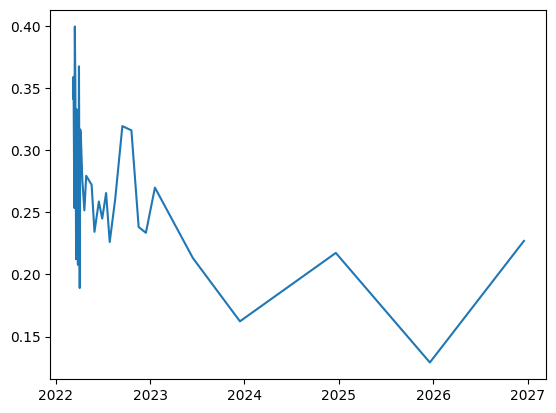

In [6]:
new_maturities = []
new_sigma_i = []
for i in range(len(maturities)):
    if sigma_i[i] > 0.001:
        new_maturities.append(maturities[i])
        new_sigma_i.append(sigma_i[i])
        
plt.plot(new_maturities,new_sigma_i)